# Proyecto Integrador (TC5035)
# Identificación de Gestos en el Lenguaje de Manos Mexicano
---
## EQUIPO 51
- CARLOS MIGUEL ARVIZU DURÁN - A01410682
- YOHANNA CEBALLOS SALOMÓN - A01795115
- RUBÉN DÍAZ GARCÍA - A01371849

## Profesores
- PROFESOR ASESOR: DR. RAÚL VALENTE RAMÍREZ VELARDE
- PROFESORA TITULAR: DRA. GRETTEL BARCELÓ ALONSO
- PROFESOR TITULAR: DR. LUIS EDUARDO FALCÓN MORALES
- PROFESORA ASISTENTE: MTRA. VERÓNICA SANDRA GUZMÁN DE VALLE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Descripción del conjunto de datos**

El Mexican Sign Language Dataset (Espejel, Josue; Dominguez, Laura Y.; Cervantes, Jair; Cervantes, Jared, 2023) constituye un recurso diseñado para el reconocimiento automático de señas en Lengua de Señas Mexicana (LSM). El conjunto incluye 249 palabras seleccionadas a partir del vocabulario básico de la infancia, organizadas en 15 subconjuntos semánticos: saludos, tiempo, días de la semana, meses, útiles escolares, familia, objetos de casa, adjetivos, cocina, ropa, partes del cuerpo, vehículos, lugares, pronombres, verbos, profesiones y estados de México.

La estructura de los datos sigue una jerarquía clara:

* Nivel 1 (palabra): cada carpeta corresponde a una clase (una palabra
en LSM).

* Nivel 2 (variación): dentro de cada palabra, se encuentran subcarpetas que representan variaciones individuales realizadas por distintas personas.

* Nivel 3 (datos): cada variación contiene un archivo de video y una secuencia de imágenes en formato JPG que representan los fotogramas de la seña. El número de fotogramas varía en función de la duración del gesto.

  
<br>  
Créditos: Espejel, Josue; Dominguez, Laura Y.; Cervantes, Jair; Cervantes, Jared (2023), “Mexican sign language dataset”, Mendeley Data, V1, doi: 10.17632/6rj76z6y3n.1

# **Importar librerias**

In [2]:
import pandas as pd
import numpy as np
import zipfile
import os
import shutil
import os
from IPython.display import Video, display
import seaborn as sns
import matplotlib.pyplot as plt

# **Metadata de videos e imágenes**

In [3]:
#Extraer el zip con el dataset
zip_path = "/content/drive/MyDrive/ProyectoIntegrador_CarpetaCompartida_LSM/Datasets LSM/LSM - Kaggle.zip"
extract_path = "/content/dataset_lsm"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

#Mover el archivo clases fuera de la carpeta MSLwords1
source_path = "/content/dataset_lsm/Mexican sign language dataset/MSLwords1/classes.xlsx"
destination_path = "/content/dataset_lsm/classes.xlsx"
os.rename(source_path, destination_path)

#Crear dataframe de metadata
palabras = os.listdir("/content/dataset_lsm/Mexican sign language dataset/MSLwords1")
palabras_path = "/content/dataset_lsm/Mexican sign language dataset/MSLwords1"

data = []

for palabra in palabras:
    ruta_palabra = os.path.join(palabras_path, palabra)
    variaciones = os.listdir(ruta_palabra)

    for variacion in variaciones:
        ruta_var = os.path.join(ruta_palabra, variacion)
        archivos = os.listdir(ruta_var)

        videos = [f for f in archivos if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]
        frames = [f for f in archivos if f.lower().endswith(('.jpg', '.png'))]

        data.append({
            "palabra": palabra,
            "variacion": variacion,
            "num_videos": len(videos),
            "num_frames": len(frames)
        })

df = pd.DataFrame(data)
df.head()

palabra variacion  num_videos  num_frames
0     164     10164           1          14
1     164     04164           1          15
2     164     05164           1          10
3     164     09164           1          14
4     164     08164           1          10

# **Índice de palabras**

In [4]:
#Cargar archivo índice de palabras
df_palabras = pd.read_excel(destination_path)
df_palabras.head()

Class number           Word    grouping
0             1    Good morning  Greetings
1             2  Good afternoon        NaN
2             3      Good night        NaN
3             4       Thank you        NaN
4             5          Please        NaN

In [5]:
#Rellenar filas
df_palabras['grouping'] = df_palabras['grouping'].fillna(method='ffill')
df_palabras.head()

/tmp/ipython-input-2967799616.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_palabras['grouping'] = df_palabras['grouping'].fillna(method='ffill')


Class number           Word    grouping
0             1    Good morning  Greetings
1             2  Good afternoon  Greetings
2             3      Good night  Greetings
3             4       Thank you  Greetings
4             5          Please  Greetings

# **Conjunción de Metadata con Índice**

In [6]:
#Merge de los dataframes que tenemos
df['palabra'] = df['palabra'].astype(int)
df_lsm = df.merge(df_palabras, left_on='palabra', right_on = 'Class number', how='left')
df_lsm = df_lsm.drop('Class number', axis=1)
df_lsm.rename(columns={'palabra': 'indice_palabra', 'Word ' : 'palabra', 'grouping':'grupo'}, inplace=True)
display(df_lsm)

indice_palabra variacion  num_videos  num_frames   palabra    grupo
0                164     10164           1          14     Hotel   Places
1                164     04164           1          15     Hotel   Places
2                164     05164           1          10     Hotel   Places
3                164     09164           1          14     Hotel   Places
4                164     08164           1          10     Hotel   Places
...              ...       ...         ...         ...       ...      ...
2442             119     03119           1          15  Necklace  Clothes
2443             119     01119           1          14  Necklace  Clothes
2444             119     04119           1          15  Necklace  Clothes
2445             119     09119           1          12  Necklace  Clothes
2446             119     07119           1          11  Necklace  Clothes

[2447 rows x 6 columns]

**Resumen de dataset**

In [7]:
#Confirmar que las palabras coinciden con la cantidad de videos
print("Número total de palabras:", df_lsm['palabra'].nunique())
print("Número total de variaciones:", df_lsm['variacion'].nunique())
print("Videos totales:", df_lsm['num_videos'].sum())
print("Frames totales:", df_lsm['num_frames'].sum())

Número total de palabras: 248
Número total de variaciones: 2446
Videos totales: 2447
Frames totales: 31409


Hay un video dúplicado

In [8]:
#Revisar que variación está duplicada
print("Conteo de cada variación única:")
df_lsm['variacion'].value_counts().head()

Conteo de cada variación única:


variacion
08248    2
03244    1
09244    1
02244    1
07244    1
Name: count, dtype: int64

In [9]:
#Palabras con la variación duplicada
for row in df.itertuples():
    if row.variacion == '08248':
      print(row.palabra)

249
248


In [10]:
#Buscar el primer archivo de video en la carpeta

def mostrar_video(path_carpeta):
    extensiones_video = ('.mp4', '.mov', '.avi', '.mkv')
    archivos = os.listdir(path_carpeta)
    for archivo in archivos:
        if archivo.lower().endswith(extensiones_video):
            video_path = os.path.join(path_carpeta, archivo)
            display(Video(video_path, embed=True, width=400, height=300))
            return
    print("No se encontró ningún archivo de video en:", path_carpeta)

In [11]:
mostrar_video("/content/dataset_lsm/Mexican sign language dataset/MSLwords1/249/08248")

In [12]:
mostrar_video("/content/dataset_lsm/Mexican sign language dataset/MSLwords1/248/08248")

El video no corresponde a la palabra Zacatecas

In [13]:
# Eliminar la variación mal alocada en la palabra Zacatecas de los archivos
carpeta_a_borrar = "/content/dataset_lsm/Mexican sign language dataset/MSLwords1/249/08248"

if os.path.exists(carpeta_a_borrar):
    shutil.rmtree(carpeta_a_borrar)
    print(f"Carpeta eliminada: {carpeta_a_borrar}")
else:
    print("La carpeta no existe.")

Carpeta eliminada: /content/dataset_lsm/Mexican sign language dataset/MSLwords1/249/08248


In [14]:
# Eliminar la variación mal alocada en la palabra Zacatecas del conjunto de datos
indice_to_drop = 249
variacion_to_drop = '08248'

df_lsm = df_lsm[
    ~((df_lsm['indice_palabra'] == indice_to_drop) & (df_lsm['variacion'] == variacion_to_drop))
]

print(f"Filas con indice_palabra={indice_to_drop} y variacion='{variacion_to_drop}' eliminadas del DataFrame.")

Filas con indice_palabra=249 y variacion='08248' eliminadas del DataFrame.


# **EDA**

Variaciones sin frames: 0
Variaciones sin video: 0


        indice_palabra variacion  num_videos   num_frames  palabra  \
count      2446.000000      2446      2446.0  2446.000000     2437   
unique             NaN      2446         NaN          NaN      248   
top                NaN     07119         NaN          NaN  Husband   
freq               NaN         1         NaN          NaN       11   
mean        119.600572       NaN         1.0    12.835650      NaN   
std          71.510374       NaN         0.0     2.546093      NaN   
min           1.000000       NaN         1.0     5.000000      NaN   
25%          58.000000       NaN         1.0    11.000000      NaN   
50%         116.500000       NaN         1.0    13.000000      NaN   
75%         180.000000       NaN         1.0    14.000000      NaN   
max         249.000000       NaN         1.0    33.000000      NaN   

                   grupo  
count               2446  
unique                17  
top     States of México 

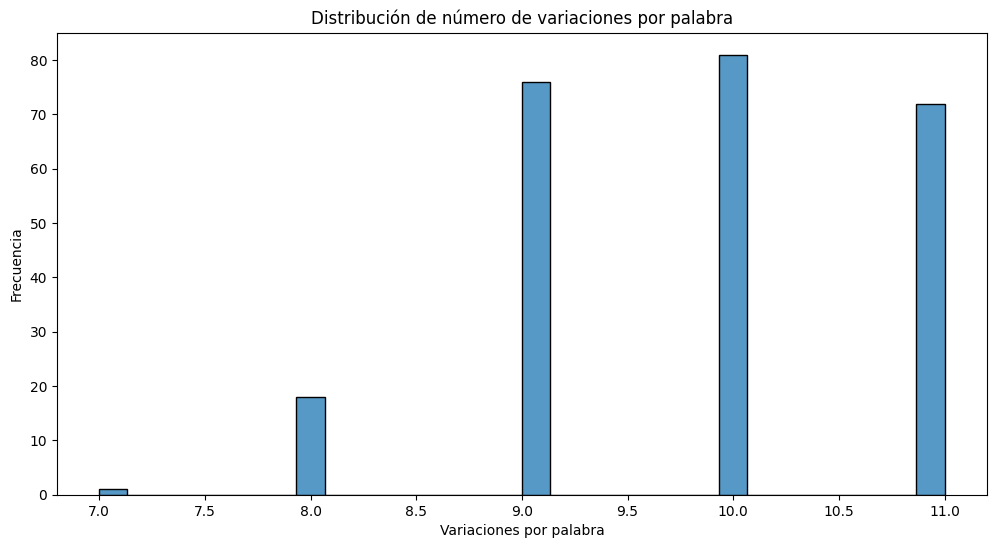

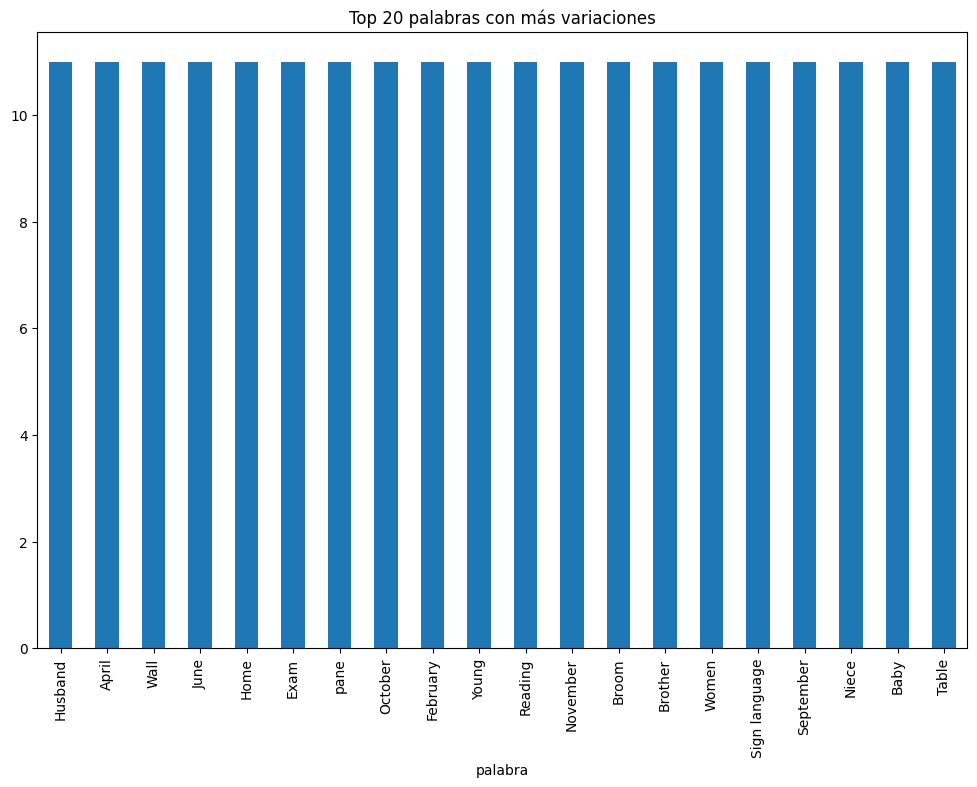

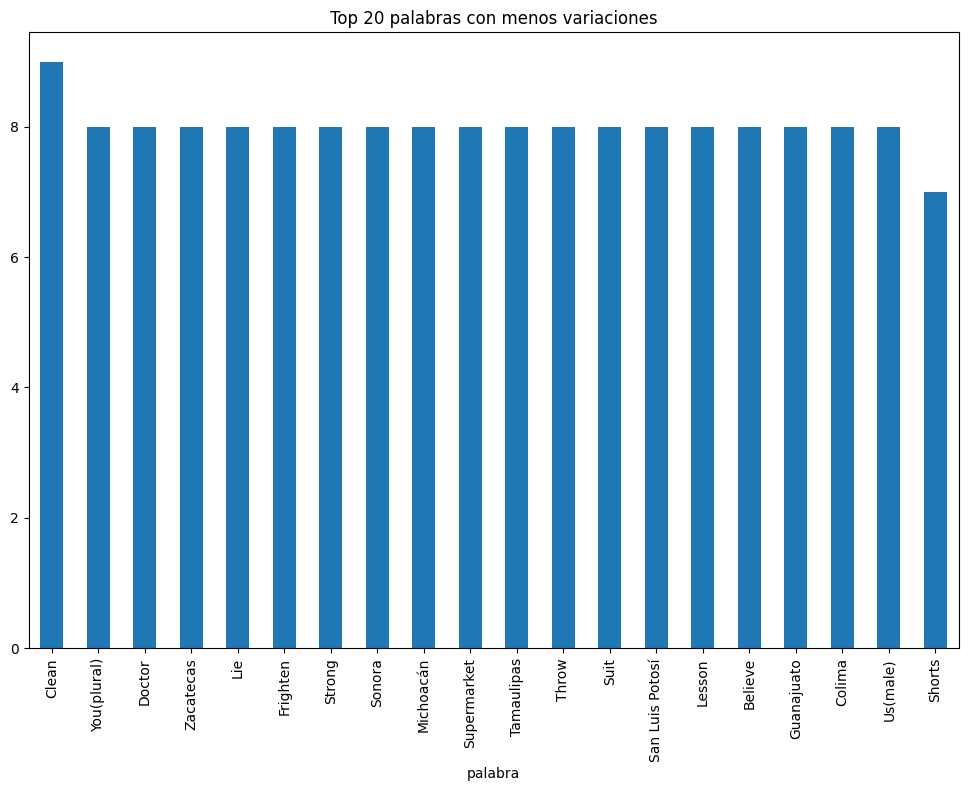

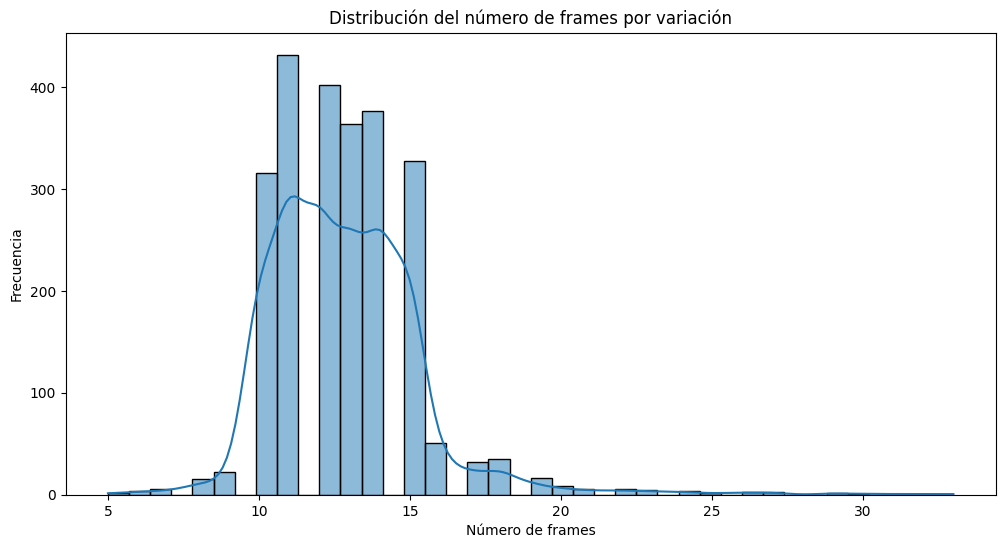

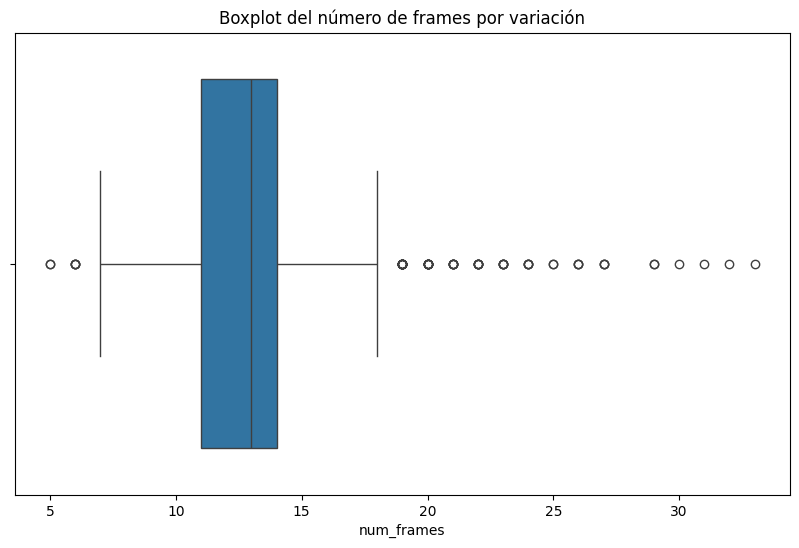

In [15]:
# 1. Data faltante
missing_frames = df_lsm[df_lsm["num_frames"] == 0]
print("Variaciones sin frames:", missing_frames.shape[0])

missing_video = df_lsm[df_lsm["num_videos"] == 0]
print("Variaciones sin video:", missing_video.shape[0])

print("\n")
# 2. Desripción de dataset
print(df_lsm.describe(include="all"))

print("\n")
# 3. Outliers en cantidad de frames
q1 = df_lsm["num_frames"].quantile(0.25)
q3 = df_lsm["num_frames"].quantile(0.75)
iqr = q3 - q1
outliers = df_lsm[(df_lsm["num_frames"] < (q1 - 1.5 * iqr)) | (df_lsm["num_frames"] > (q3 + 1.5 * iqr))]
print("Variaciones con número de frames atípico:", outliers.shape[0])

print("\n")
# 4. Cardinalidad de clases (palabras)
class_counts = df_lsm["palabra"].value_counts()
plt.figure(figsize=(12,6))
sns.histplot(class_counts, bins=30, kde=False)
plt.title("Distribución de número de variaciones por palabra")
plt.xlabel("Variaciones por palabra")
plt.ylabel("Frecuencia")
plt.show()

print("\n")
# 5. Balance de clases (palabras)
plt.figure(figsize=(12,8))
class_counts.head(20).plot(kind='bar')
plt.title("Top 20 palabras con más variaciones")
plt.show()

print("\n")
plt.figure(figsize=(12,8))
class_counts.tail(20).plot(kind='bar')
plt.title("Top 20 palabras con menos variaciones")
plt.show()

print("\n")
# 6. Distribución de frames
plt.figure(figsize=(12,6))
sns.histplot(df_lsm["num_frames"], bins=40, kde=True)
plt.title("Distribución del número de frames por variación")
plt.xlabel("Número de frames")
plt.ylabel("Frecuencia")
plt.show()

print("\n")
plt.figure(figsize=(10,6))
sns.boxplot(x=df_lsm["num_frames"])
plt.title("Boxplot del número de frames por variación")
plt.show()


Para ver si los valores atípicos son debido a un grupo de palabras específico:

In [16]:
outliers['palabra'].value_counts()

palabra
Supermarket      4
Sign language    3
Firefighter      2
Waiter           2
Exam             2
Café             2
Nuevo León       1
Secretary        1
Teacher          1
Throw            1
Durango          1
Chiapas          1
Fat              1
Saturday         1
Table            1
Tamaulipas       1
Reading          1
Niece            1
Michoacán        1
Qualification    1
Pijama           1
Bed              1
Minutes          1
Friday           1
Kitchen          1
Restaurant       1
Tractor          1
Curtain          1
You              1
Actor            1
Guanajuato       1
March            1
Good morning     1
Fork             1
Taxi             1
Thursday         1
pants            1
Querétaro        1
Carpenter        1
Play             1
Notebook         1
Building         1
Jalisco          1
They(female)     1
Clean            1
Eraser           1
Nephew           1
Knife            1
Man              1
Shoemaker        1
Closet           1
Hidalgo          1
Quintana Roo     1
She              1
Hall             1
Guerrero         1
Breakfast        1
Name: count, dtype: int64

# **Conclusiones**

In [17]:
conclusiones = []
if not missing_frames.empty:
  conclusiones.append(f"Se detectaron {missing_frames.shape[0]} variaciones sin frames.")
if not missing_video.empty:
  conclusiones.append(f"Se detectaron {missing_video.shape[0]} variaciones sin video.")
if not outliers.empty:
  conclusiones.append(f"Hay {outliers.shape[0]} variaciones con un número atípico de frames.")
if class_counts.min() != class_counts.max():
  conclusiones.append("Se observa desequilibrio en el número de variaciones entre clases (palabras).")

print("\n".join(conclusiones) if conclusiones else "No se detectaron problemas relevantes.")

Hay 66 variaciones con un número atípico de frames.
Se observa desequilibrio en el número de variaciones entre clases (palabras).


**Número de clases y variaciones**

El dataset contiene 249 palabras representadas por múltiples variaciones realizadas por distintas personas. La distribución de variaciones por clase es bastante homogénea: la mayoría de las palabras cuentan con entre 9 y 11 variaciones, mientras que solo una minoría presenta 8 variaciones y únicamente una palabra tiene 7. Este balance es positivo, ya que asegura una cobertura adecuada de ejemplos para la mayoría de las clases.


**Distribución de frames por video**

La gran mayoría de los videos se encuentra entre los 10 y 15 frames, lo que indica consistencia en la duración de los gestos. No obstante, se identificaron 66 variaciones con un número atípico de frames. Estos valores no representan errores de captura, sino que reflejan diferencias naturales en la duración de la ejecución de los gestos. Dado que no hay una relación directa entre la longitud del gesto y la clase, estas muestras no afectan la validez del dataset.

**Desequilibrio en el dataset**

Aunque se observa un leve desequilibrio en el número de variaciones por palabra, este no es crítico. La inmensa mayoría de clases está bien representada, con solo unos pocos casos con menor número de ejemplos. Sin embargo, este aspecto debe ser tenido en cuenta en etapas posteriores de modelado, ya que puede influir en la capacidad del modelo para generalizar adecuadamente en las clases menos representadas.

**Contexto y calidad del dataset**

El dataset proviene de un entorno controlado, con condiciones uniformes de grabación (fondo oscuro y un solo gesto por video). Esto contribuye positivamente a la consistencia y calidad de los datos, reduciendo la variabilidad introducida por factores externos y facilitando su uso para tareas de clasificación.


En resumen, el dataset presenta un buen nivel de homogeneidad en la mayoría de sus dimensiones, con un número de clases amplio (249) y una distribución de variaciones bastante equilibrada. Si bien existen algunas diferencias en la cantidad de variaciones y en la longitud de ciertos gestos, estas no comprometen la validez del conjunto. Los hallazgos permiten concluir que el dataset es adecuado para tareas de clasificación de gestos, siempre considerando que el leve desequilibrio y la presencia de secuencias más largas pueden requerir ajustes metodológicos en etapas posteriores.